# Skip-thought vectors & Similarity Learning

The goal of this notebook is to experiment with the opportunities that sentence2vec (here skip-thought) embedding offer for the task of question similarities . 

NB : You need to download the skip-thought code + the pre-trained models to run this ipynb (cf github rep link below)

Usefull links:
- Paper : https://arxiv.org/abs/1506.06726
- Github rep : https://github.com/ryankiros/skip-thoughts
        
First, we use a naive approach in which we just use as is the sentence embeddings provided by the skip-thouth 
model, i.e. provided 2 questions, we compute their similarity as the cosine similarity between their vectorize representation.
It turns out it does not work that well : 2 questions asked with a similar grammatical structure but different meaning will be attributed a relatively high score, so it does not allow to distinguish that from a semantically similar question asked in a grammatically different way. The reason for that seems to be that sentence2vec-like models do not only encode semantic but also sentences structure.

To solve this issue, we try to learn a projection matrix in hope to learn which dimensions of the encoding would be 
more related to semantic and which one related to structure (this is part of similarity learning). 
I.e. instead of computing <question1, question2> to get a similarity score, we compute user_question.W.hc_question 
and try to supervisely learn W (with regularization, and initializing M as the identity matrix).

For more on similarity learning, check wikipedia page :
https://en.wikipedia.org/wiki/Similarity_learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/vincentchabot/Desktop/capstone/skip_thoughts/skip-thoughts-master/')
import skipthoughts
import numpy as np

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
# make sure to download & provide the correct path to your /models repository in skipthoughts.py
model = skipthoughts.load_model()

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


## #1 Similarity on sentences skip-thought embeddings

In [4]:
# Toy example
X = ['what is the number of cars in the base ?',
     'how many vehicles do i have in my database ?',
     'what is the number of users in the base ?']

In [5]:
# Create array of the embeded sentences
vectors_X = skipthoughts.encode(model, X, verbose=False)

In [6]:
def sentence_cosine_sim(vectors, sent1_index, sent2_index):
    '''
    find pairwise cosine similarity between sentence1 and sentence2
    '''
    s1, s2 = vectors[sent1_index], vectors[sent2_index]
    cosine_similarity = np.dot(s1, s2)/(np.linalg.norm(s1) * np.linalg.norm(s2))
    return cosine_similarity

print 'sentence_cosine_sim between :\n'
print X[0] 
print 'and'
print X[1]
print "similarity: ", sentence_cosine_sim(vectors_X, 0, 1)

print '\nsentence_cosine_sim between :\n'
print X[0] 
print 'and'
print X[2]
print "similarity: ", sentence_cosine_sim(vectors_X, 0, 2)

sentence_cosine_sim between :

what is the number of cars in the base ?
and
how many vehicles do i have in my database ?
similarity:  0.819562

sentence_cosine_sim between :

what is the number of cars in the base ?
and
what is the number of users in the base ?
similarity:  0.95662


##### --> 2 questions asked with a similar grammatical structure but different meaning will be attributed a relatively high score, so it does not allow to distinguish that from a semantically similar question asked in a grammatically different way.

## #2 Similarity learning on top of skip-thought embeddings

#### (a) Load and clean the data, create train/test sets 

In [7]:
import re
import pandas as pd

def clean_str(string):
    """
    Tokenization/string cleaning strings
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip('\n').strip().lower()

def load_data(path, file_name):
    df = pd.read_csv(path + file_name, sep='\t', header=None)
    df.columns = ['hardcoded_question']
    for i in df.index:
        df['hardcoded_question'][i] = clean_str(df['hardcoded_question'][i])
    return df

def load_test_data(path, file_name):
    df = pd.read_csv(path + file_name, sep='\t', header=None)
    df.columns = ['hardcoded_question', 'user_question']
    for i in df.index:
        df['hardcoded_question'][i] = clean_str(df['hardcoded_question'][i])
        df['user_question'][i] = clean_str(df['user_question'][i])
    return df 

# upload data
print "loading data...\n"
print "loading hardcoded_question_set...\n"
path_train = '/Users/vincentchabot/Desktop/capstone/Data2/'
file_name_train = 'test2.txt' 
hardcoded_question_set = load_data(path_train, file_name_train)
print "loading test set...\n"
path_test = '/Users/vincentchabot/Desktop/capstone/Data2/'
file_name_test = 'test_set2.tsv' 
test_set = load_test_data(path_test, file_name_test)

loading data...

loading hardcoded_question_set...

loading test set...



In [8]:
test_set.head()

,hardcoded_question,user_question
0,do i have risky customers \?,what are the clients at risk \?
1,how can i change my password \?,i lost my password how can i have a new one \?
2,are there blocked invoices \?,how many invoices are blocked \?
3,how many vehicles do i have in my database \?,what is the number of cars in the base \?
4,does snow fall in egypt \?,is there snow in egypt \?


In [9]:
train = test_set[0:19]
test = test_set[20:27]

# reindex test dataframe
test.index = range(7)

In [10]:
# Here, we create a hardcoded_question / user_question pair set
# we create all the possible question pairs in order to have as many pairs as possible to train on.
# For each hardcoded question, only 1 pair will be correct and all the other will be false.
def create_sentence_pairset(data):
    '''
    Output =  {(hardcoded_question, user_question) : ((hardcoded_question_vector, user_question_vector, correct))}
    with correct being 1 if the user question corresponds to the hardcoded question, 0 otherwise
    '''
    sentence_pairset = {}
    hqs = data['hardcoded_question'].tolist()
    uqs = data['user_question'].tolist()
    hqs_vectors = skipthoughts.encode(model, hqs, verbose=False)
    uqs_vectors = skipthoughts.encode(model, uqs, verbose=False)
    # Normalize
    for i in range(hqs_vectors.shape[0]):
        hqs_vectors[i] /= np.linalg.norm(hqs_vectors[i])
        uqs_vectors[i] /= np.linalg.norm(hqs_vectors[i])
    for hq in hqs:
        for uq in uqs:
            if hqs.index(hq) == uqs.index(uq):
                sentence_pairset[(hq,uq)] = (hqs_vectors[hqs.index(hq)], uqs_vectors[uqs.index(uq)], 1.0)
            else:
                sentence_pairset[(hq,uq)] = (hqs_vectors[hqs.index(hq)], uqs_vectors[uqs.index(uq)], 0.0)
    return sentence_pairset

train_sentence_pairset = create_sentence_pairset(train)
test_sentence_pairset = create_sentence_pairset(test)

#### (b) Learning the projection matrix W

In [38]:
from random import randint

def compute_square_loss(sentence_pairset, Lambda, W, embedding_length):
    loss = 0
    values_computed = 0.0
    for value in sentence_pairset.itervalues():
        
        # Since there are way more false pairs than true pairs, we can balance this ratio by taking only 
        # 1 false pair every x false pairs. Otherwise, the final W matrix will be biaised toward false pairs
        # and will only produce very small scores
        compute_gradient = True
        '''
        correct = value[2]
        if correct == 1.0:
            compute_gradient = True
        elif correct == 0.0:
            if randint(0,9)==0:
                compute_gradient = True
            else:
                compute_gradient = False
        '''
        
        if compute_gradient: 
            hq_vector = value[0].reshape((embedding_length,1))
            uq_vector = value[1].reshape((embedding_length,1))
            correct = value[2]
            hq_vectorT = np.transpose(hq_vector)
            uq_vectorT = np.transpose(uq_vector)
            loss += np.linalg.norm(correct - np.dot(hq_vectorT, np.dot(W,uq_vector)))
            values_computed += 1.0
            
    loss /= 2*values_computed
    loss += Lambda*(np.linalg.norm(W))**2
    return loss


def compute_regularized_square_loss_gradient(sentence_pairset, embedding_length, Lambda, W):
    """
    Compute the gradient of L2-regularized square loss function 
    """
    gradient = np.zeros((embedding_length, embedding_length))
    values_computed = 0.0
    for value in sentence_pairset.itervalues():
        
        # Since there are way more false pairs than true pairs, we can balance this ratio by taking only 
        # 1 false pair every x false pairs. Otherwise, the final W matrix will be biaised toward false pairs
        # and will only produce very small scores
        compute_gradient = True
        '''
        correct = value[2]
        if correct == 1.0:
            compute_gradient = True
        elif correct == 0.0:
            if randint(0,9)==0:
                compute_gradient = True
            else:
                compute_gradient = False
        '''
        
        if compute_gradient: 
            hq_vector = value[0].reshape((embedding_length,1))
            uq_vector = value[1].reshape((embedding_length,1))
            correct = value[2]
            hq_vectorT = np.transpose(hq_vector)
            uq_vectorT = np.transpose(uq_vector)
            gradient += - np.dot(hq_vector, uq_vectorT) * (correct - np.dot(hq_vectorT, np.dot(W,uq_vector)))
            values_computed += 1.0
        
    gradient /= values_computed
    gradient += 2*Lambda*W
    return gradient


def regularized_grad_descent(sentence_pairset, alpha=0.1, Lambda=10, num_iter=10):
    """
    Args:
        sentence_pairset = sentence pairs + correct value (1 if they sementically correspond, 0 otherwise)
        alpha - step size in gradient descent
        Lambda - the regularization coefficient
        num_iter - number of iterations to run 
        
    Returns:
        W_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features) 
        loss_hist - the history of regularized loss value, 1D numpy array
    """
    # initialize W as Identity matrix
    embedding_length = skipthoughts.encode(model, ['random'], verbose=False).shape[1]
    W = np.identity(embedding_length)
    
    # initialize W_hist and loss_hist
    W_hist = np.zeros((num_iter+1, embedding_length, embedding_length)) 
    loss_hist = np.zeros(num_iter+1)  
    W_hist[0]=W
    loss_hist[0]=compute_square_loss(sentence_pairset, Lambda, W, embedding_length)
    
    for i in range(1,num_iter+1):
        print 'iteration number ', i
        W = W - alpha*compute_regularized_square_loss_gradient(sentence_pairset, embedding_length, Lambda, W)
        # Normalize
        W_norm = np.linalg.norm(W)/np.linalg.norm(W_hist[0])
        W = W/W_norm
        W_hist[i]=W
        loss_hist[i]=compute_square_loss(sentence_pairset, Lambda, W, embedding_length)
    return W_hist, loss_hist

In [39]:
# Learn W
# Multiplying num_iter by 15 because we are only taking 1 false pair every 15 false pairs in training 
n_iter = 15
alph = 0.1
W_hist, loss_hist = regularized_grad_descent(train_sentence_pairset, alpha=alph, Lambda=1, num_iter=n_iter)

iteration number  1
iteration number  2
iteration number  3
iteration number  4
iteration number  5
iteration number  6
iteration number  7
iteration number  8
iteration number  9
iteration number  10
iteration number  11
iteration number  12
iteration number  13
iteration number  14
iteration number  15


##### --> Let's check how the learning went

In [40]:
def compute_test_loss(sentence_pairset, W_hist, Lambda, num_iter):
    #Initialize loss_hist
    test_loss_hist = np.zeros(num_iter+1)   
    for i in range(num_iter+1):
        test_loss_hist[i]=compute_square_loss(sentence_pairset, Lambda, W_hist[i], embedding_length)
    return test_loss_hist

n_iter = 15
embedding_length = skipthoughts.encode(model, ['random'], verbose=False).shape[1]
test_loss_hist = compute_test_loss(test_sentence_pairset, W_hist, Lambda=1, num_iter=n_iter)

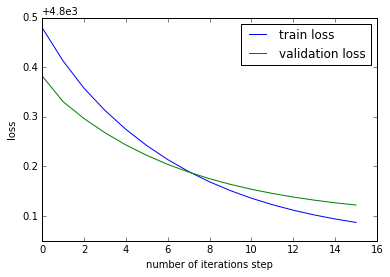

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(loss_hist, label='train loss')
plt.plot(test_loss_hist, label='validation loss')

plt.legend()
plt.xlabel('number of iterations step')
plt.ylabel('loss')
plt.show()

From the loss plot, the learning seems to work

##### (c) Let's see the results on the toy example from the begining

In [47]:
X = ['what is the number of cars in the base ?',
     'how many vehicles do i have in my database ?',
     'what is the number of users in the base ?']

vectors_X = skipthoughts.encode(model, X, verbose=False)

def sentence_cosine_sim_with_W(vectors, sent1_index, sent2_index, W):
    '''
    find pairwise cosine similarity between sentence1 and sentence2
    '''
    # first, embed sentences
    s1, s2 = vectors[sent1_index], vectors[sent2_index]
    # second, compute cosine similarity
    cosine_similarity = np.dot(np.transpose(s1), np.dot(W,s2))/(np.linalg.norm(s1) * np.linalg.norm(s2) )
    return cosine_similarity

In [48]:
print 'sentence_cosine_sim between :\n'
print X[0] 
print 'and'
print X[1]
print "similarity: ", sentence_cosine_sim_with_W(vectors_X, 0, 1, W_hist[-1])

print '\nsentence_cosine_sim between :\n'
print X[0] 
print 'and'
print X[2]
print "similarity: ", sentence_cosine_sim_with_W(vectors_X, 0, 2, W_hist[-1])

sentence_cosine_sim between :

what is the number of cars in the base ?
and
how many vehicles do i have in my database ?
similarity:  0.161234690071

sentence_cosine_sim between :

what is the number of cars in the base ?
and
what is the number of users in the base ?
similarity:  0.263535810462


###### --> We observe that scores are both lower but the score for a true pair is still not greater than the score for a false pair.

## Conclusion

1) The fact that from the very little available data we had we constructed a data set that has 26 times more false pairs than true pairs, the framework learnt a W that tends to lower all the scores and tends to predict false all the time. Using the AUC as metric should give better results.

2) Learning a 3800x3800 matrix from 20 examples is of course way too ambitious. But at least the similarity learning framework we've built shows that it is possible to learn such a projection matrix using sentence embedding like skip-thought and might be reuse once more data is available. Furthermore, such a framework could also be used on other sentence embeddings we built otherwise, like the one using word2vec embeddings + CBOW.